In [1]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
# load train, test, validation splits
saved_dir = 'D:/JATHURSH/Jupyter_notebook_projects/DistractionDetectFinal/saved_data/splits_preprocessed/'

saved_dir_2 = 'D:/JATHURSH/Jupyter_notebook_projects/DistractionDetectFinal/saved_data/splits/'

X_train = np.load(saved_dir + 'X_train.npy')

X_val = np.load(saved_dir + 'X_val.npy')

y_train = np.load(saved_dir_2 + 'y_train.npy')

y_val = np.load(saved_dir_2 + 'y_val.npy')

In [3]:
# pretrained model - MobileNetV2
# all should be numpy arrays or tensors before giving it to MobileNetV2
"""
    tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=None,                 # Shape of input data (MobileNets support any input size greater than 32 x 32, with larger image sizes offering better performance.) 
    alpha=1.0,                        # Width multiplier for controlling network width (default is 1.0)
    include_top=True,                 # Include fully connected top layers (default is True)
    weights='imagenet',               # Weight initialization ('imagenet' for pre-trained weights, None for random initialization)
    input_tensor=None,                # Optional input tensor (default is None)
    pooling=None,                     # Pooling type for the last layer ('avg', 'max', or None; default is None)
    classes=1000,                     # Number of output classes (default is 1000 for ImageNet)
    classifier_activation='softmax',   # Activation function for output layer (default is 'softmax')
    **kwargs                          # Additional keyword arguments
    )
"""
# we dont have to set anything and keep its default values
MobileNetV2_model = tf.keras.applications.mobilenet_v2.MobileNetV2()
    
# Make all layers in the model non-trainable - freeze
for layer in MobileNetV2_model.layers:
    layer.trainable = False

# for reproducability - can be used between different runtimes
tf.random.set_seed(42)

# Get the base model's input and output
base_input = MobileNetV2_model.layers[0].input
base_output = MobileNetV2_model.layers[-3].output
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_output)

dense_layer = tf.keras.layers.Dense(256, activation='relu')(global_average_layer) 
dropout_layer = tf.keras.layers.Dropout(0.4)(dense_layer)
final_output = tf.keras.layers.Dense(8)(dropout_layer)
final_output = tf.keras.layers.Activation("softmax")(final_output)

In [4]:
distraction_detection_model = tf.keras.Model(
    inputs=base_input,
    outputs=final_output
)

In [5]:
# one hot encoding the lebels
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train, num_classes=8)
y_val_encoded = to_categorical(y_val, num_classes=8)
y_train_encoded[:2], y_val_encoded[:2]

(array([[0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32),
 array([[0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32))

In [6]:
# Compile and train the model using X_train - preprocessed as input
initial_learning_rate = 0.001

# Use the ReduceLROnPlateau learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
)

distraction_detection_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate), 
                                   loss='categorical_crossentropy', 
                                   metrics=['accuracy'])

history_of_model = distraction_detection_model.fit(
                               X_train, 
                               y_train_encoded, 
                               epochs=30, 
                               batch_size=32, 
                               validation_data=(X_val, y_val_encoded),
                               callbacks=[tf.keras.callbacks.EarlyStopping(patience=5), lr_scheduler])

Epoch 1/30
822/822 [==============================] - 908s 1s/step - loss: 0.7157 - accuracy: 0.7560 - val_loss: 0.2969 - val_accuracy: 0.9157 - lr: 0.0010
Epoch 2/30
822/822 [==============================] - 676s 822ms/step - loss: 0.3083 - accuracy: 0.9008 - val_loss: 0.2173 - val_accuracy: 0.9370 - lr: 0.0010
Epoch 3/30
822/822 [==============================] - 495s 602ms/step - loss: 0.2435 - accuracy: 0.9211 - val_loss: 0.1558 - val_accuracy: 0.9501 - lr: 0.0010
Epoch 4/30
822/822 [==============================] - 508s 618ms/step - loss: 0.1950 - accuracy: 0.9371 - val_loss: 0.1134 - val_accuracy: 0.9665 - lr: 0.0010
Epoch 5/30
822/822 [==============================] - 492s 599ms/step - loss: 0.1630 - accuracy: 0.9468 - val_loss: 0.1115 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 6/30
822/822 [==============================] - 494s 601ms/step - loss: 0.1545 - accuracy: 0.9476 - val_loss: 0.0858 - val_accuracy: 0.9702 - lr: 0.0010
Epoch 7/30
822/822 [=============================

In [7]:
# Save the model architecture and weights
save_dir = 'D:/JATHURSH/Jupyter_notebook_projects/DistractionDetectFinal/saved_data/models/'

distraction_detection_model.save(save_dir + 'dis_det_model.h5')

# Save the history object to a file
with open(save_dir + 'dis_det_model_history.pkl', 'wb') as file:
    pickle.dump(history_of_model.history, file)

C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
training_loss = history_of_model.history['loss']
validation_loss = history_of_model.history['val_loss']

training_accuracy = history_of_model.history['accuracy']
validation_accuracy = history_of_model.history['val_accuracy']

# Calculate the number of training epochs:
# - `len(training_loss)` calculates the length of the training_loss list, which typically
#   contains the loss value at the end of each training epoch.
# - This length tells us how many epochs the machine learning model was trained for.

# Create a range of values representing epochs:
# - `range(1, len(training_loss) + 1)` generates a Python range object starting from 1 and
#   ending at the length of the training_loss list plus one.
# - The +1 is added to ensure that the range includes values up to the number of epochs.
# - This range is often used as the x-axis when plotting training metrics against the
#   number of training iterations (epochs).
epochs = range(1, len(training_loss) + 1)

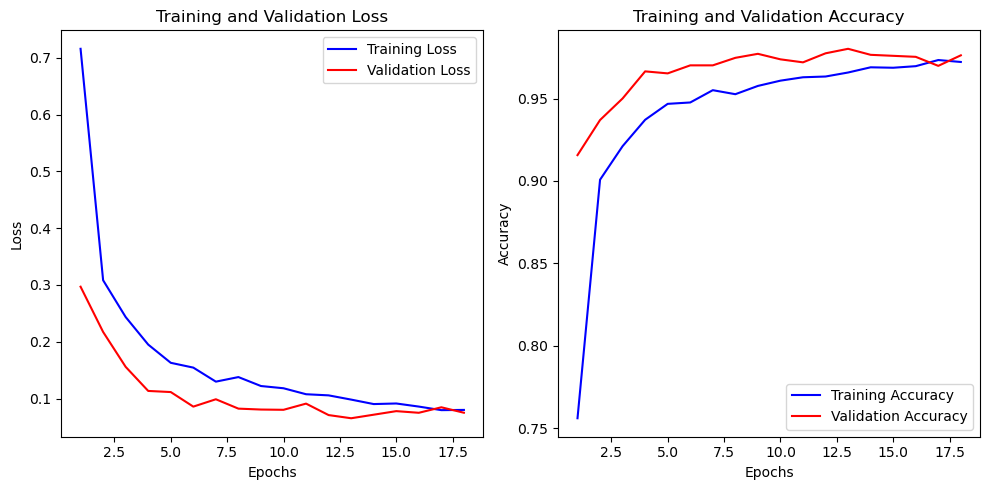

In [9]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# load test split
saved_test_dir = 'D:/JATHURSH/Jupyter_notebook_projects/DistractionDetectFinal/saved_data/splits_preprocessed/'
saved_test_dir_2 = 'D:/JATHURSH/Jupyter_notebook_projects/DistractionDetectFinal/saved_data/splits/'

X_test = np.load(saved_test_dir + 'X_test.npy')
y_test = np.load(saved_test_dir_2 + 'y_test.npy')

In [11]:
from keras.utils import to_categorical

# y_test contains integer labels so - one hot encode 
y_test_one_hot = to_categorical(y_test, num_classes=8)
y_test_one_hot[:3]

array([[0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [12]:
distraction_detection_model.evaluate(X_test, y_test_one_hot)

103/103 [==============================] - 92s 893ms/step - loss: 0.0693 - accuracy: 0.9778


[0.06931363791227341, 0.9777777791023254]

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Make predictions using trained model on the test dataset
y_pred = distraction_detection_model.predict(X_test)

103/103 [==============================] - 96s 888ms/step


In [14]:
y_pred_binary = np.argmax(y_pred, axis=1)
y_pred_binary[:1]

array([6], dtype=int64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Predicted label: 1, True label: 1')

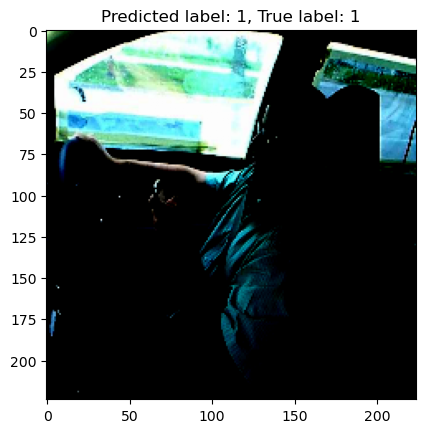

In [18]:
plt.imshow(X_test[4])
plt.title(f'Predicted label: {y_pred_binary[4]}, True label: {y_test[4]}')

In [19]:
# create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

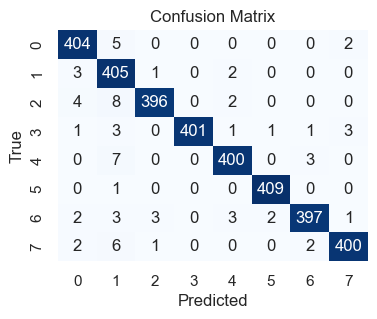

In [20]:
# Create a heatmap of the confusion matrix using seaborn
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.0)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [21]:
# create classification report
class_report = classification_report(y_test, y_pred_binary)
print(class_report)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       411
           1       0.92      0.99      0.95       411
           2       0.99      0.97      0.98       410
           3       1.00      0.98      0.99       411
           4       0.98      0.98      0.98       410
           5       0.99      1.00      1.00       410
           6       0.99      0.97      0.98       411
           7       0.99      0.97      0.98       411

    accuracy                           0.98      3285
   macro avg       0.98      0.98      0.98      3285
weighted avg       0.98      0.98      0.98      3285

